In [1]:
import os
from handcrafted.app.dataset.dataset_loader import DatasetLoader
loader = DatasetLoader()


In [2]:
import os

from handcrafted.app.dataset.dataset import Dataset
from handcrafted.app.dataset.utils.dataset_splitter import SignerDatasetSplitter
from handcrafted.app.features.plotter.frames_plotter import plot_frames
from handcrafted.app.model.model_statistics import ModelStatistics
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

import numpy as np
dataset = Dataset("data/WLASL_v0.3.json")
n_videos = 2000

2025-03-26 18:38:53.900230: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-26 18:38:53.900527: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 18:38:53.902350: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 18:38:53.930036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 18:38:54.632911: W tensorflow/compiler/tf2tensorrt/utils/py_uti

KeyboardInterrupt: 

In [2]:
videos = dataset.videos
len(videos)

11979

In [3]:
signers = [video.signer_id for video in videos]
len(signers)

11979

In [4]:
splitter = SignerDatasetSplitter(videos[:n_videos], frames_split=0.01, extract_features=False)
train_frames, val_frames, test_frames = splitter.train_test_split(test_size=0.2, val_size=0.2, random_state=42)
augmented_train_frames = splitter.apply_data_augmentation(train_frames, num_augmentations=0)

In [5]:
print(len(train_frames))
print(len(augmented_train_frames))
print(len(val_frames))
print(len(test_frames))

1382
1382
346
433


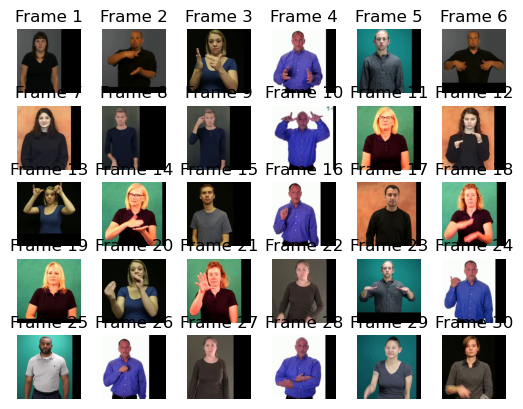

In [6]:
plot_frames([signer_frame.frame for signer_frame in augmented_train_frames[:30]])

In [7]:
X_train = [signer_frame.frame for signer_frame in augmented_train_frames]
y_train = [signer_frame.signer_id for signer_frame in augmented_train_frames]
X_val = [signer_frame.frame for signer_frame in val_frames]
y_val = [signer_frame.signer_id for signer_frame in val_frames]
X_test = [signer_frame.frame for signer_frame in test_frames]
y_test = [signer_frame.signer_id for signer_frame in test_frames]

In [8]:
# Get the total of different labels
num_classes = len(set(y_train) | set(y_val) | set(y_test))
print(num_classes)

69


In [9]:
X_train = np.array(X_train)/255.0
X_val = np.array(X_val)/255.0
X_test = np.array(X_test)/255.0

In [10]:
print('Range originale: [',np.min(X_train),';',np.max(X_train),']')

Range originale: [ 0.0 ; 1.0 ]


In [11]:
X_train = (X_train*2)-1
X_val = (X_val*2)-1
X_test = (X_test*2)-1

In [12]:
print('Range rimappato: [',np.min(X_train),';',np.max(X_train),']')

Range rimappato: [ -1.0 ; 1.0 ]


In [13]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [14]:
print(X_train.shape)
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))

(1382, 224, 224, 3)
1382
346
346
433
433


In [15]:
print(X_train[0].shape)

(224, 224, 3)


In [16]:
print(X_train.dtype)

float32


In [17]:
# Assuming y_train contains person IDs
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)  # Convert IDs to class indices
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

In [18]:
y_train_onehot = to_categorical(y_train_encoded, num_classes=num_classes)
y_val_onehot = to_categorical(y_val_encoded, num_classes=num_classes)
y_test_onehot = to_categorical(y_test_encoded, num_classes=num_classes)

In [19]:
def build_vggface():
  model=keras.Sequential(
          [
              layers.Input(shape=(224,224,3),name='input'),
              layers.Conv2D(filters=64, kernel_size=3,padding='same', activation='relu',name='conv1_1-relu1_1'),
              layers.Conv2D(filters=64, kernel_size=3,padding='same', activation='relu',name='conv1_2-relu1_2'),
              layers.MaxPooling2D(pool_size=2, strides=2,name='pool1'),
              layers.Conv2D(filters=128, kernel_size=3,padding='same', activation='relu',name='conv2_1-relu2_1'),
              layers.Conv2D(filters=128, kernel_size=3,padding='same', activation='relu',name='conv2_2-relu2_2'),
              layers.MaxPooling2D(pool_size=2, strides=2,name='pool2'),
              layers.Conv2D(filters=256, kernel_size=3,padding='same', activation='relu',name='conv3_1-relu3_1'),
              layers.Conv2D(filters=256, kernel_size=3,padding='same', activation='relu',name='conv3_2-relu3_2'),
              layers.Conv2D(filters=256, kernel_size=3,padding='same', activation='relu',name='conv3_3-relu3_3'),
              layers.MaxPooling2D(pool_size=2, strides=2,name='pool3'),
              layers.Conv2D(filters=512, kernel_size=3,padding='same', activation='relu',name='conv4_1-relu4_1'),
              layers.Conv2D(filters=512, kernel_size=3,padding='same', activation='relu',name='conv4_2-relu4_2'),
              layers.Conv2D(filters=512, kernel_size=3,padding='same', activation='relu',name='conv4_3-relu4_3'),
              layers.MaxPooling2D(pool_size=2, strides=2,name='pool4'),
              layers.Conv2D(filters=512, kernel_size=3,padding='same', activation='relu',name='conv5_1-relu5_1'),
              layers.Conv2D(filters=512, kernel_size=3,padding='same', activation='relu',name='conv5_2-relu5_2'),
              layers.Conv2D(filters=512, kernel_size=3,padding='same', activation='relu',name='conv5_3-relu5_3'),
              layers.MaxPooling2D(pool_size=2, strides=2,name='pool5'),
              layers.Conv2D(filters=4096, kernel_size=7, activation='relu',name='fc6-relu6'),
              layers.Dropout(0.5,name='do6'),
              layers.Conv2D(filters=4096, kernel_size=1, activation='relu',name='fc7-relu7'),
              layers.Dropout(0.5,name='do7'),
              layers.Conv2D(filters=num_classes, kernel_size=1,activation='softmax',name='fc8-prob'),
              layers.Flatten(name='flatten'),
          ]
        )

  return model

In [20]:
model=build_vggface()
model.summary()
keras.utils.plot_model(model,show_shapes=True, show_layer_names=True)
# model.load_weights('vgg_face_weights.h5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1_1-relu1_1 (Conv2D)        │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_2-relu1_2 (Conv2D)        │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1-relu2_1 (Conv2D)        │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_2-relu2_2 (Conv2D)        │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1-relu3_1 (Conv2D)        │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_2-relu3_2 (Conv2D)        │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_3-relu3_3 (Conv2D)        │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1-relu4_1 (Conv2D)        │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_2-relu4_2 (Conv2D)        │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_3-relu4_3 (Conv2D)        │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_1-relu5_1 (Conv2D)        │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_2-relu5_2 (Conv2D)        │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv5_3-relu5_3 (Conv2D)        │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool5 (MaxPooling2D)            │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc6-relu6 (Conv2D)              │ (None, 1, 1, 4096)     │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do6 (Dropout)                   │ (None, 1, 1, 4096)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc7-relu7 (Conv2D)              │ (None, 1, 1, 4096)     │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ do7 (Dropout)                   │ (None, 1, 1, 4096)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc8-prob (Conv2D)               │ (None, 1, 1, 69)       │       282,693 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 69)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,543,237 (513.24 MB)

 Trainable params: 134,543,237 (513.24 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [21]:
checkpoint_filepath = "model.ckpt"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_filepath, 'model_{epoch:02d}.weights.h5'),
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    mode='min',
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=50,
    restore_best_weights=True
)

model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.fit(
    X_train,
    y_train_onehot,
    batch_size=128,
    epochs=1,
    validation_data=(X_val, y_val_onehot),
    verbose=1,
)

 2/11 ━━━━━━━━━━━━━━━━━━━━ 2:24 16s/step - accuracy: 0.0664 - loss: 4.2301

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test_onehot)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
stats = ModelStatistics(save_name=f"svc_{n_videos}_signer_test_{len(y_test)}", save_dir="signer/plots")

In [ ]:
stats.print_accuracy(y_test_onehot, y_pred)

In [ ]:
stats.plot_confusion_matrix(y_test, y_pred, save=True, plot=True